In [131]:

import os
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import scikitplot as skplt
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import joblib

### Cleaning Data

In [73]:

def data_combine(data_dir,v_object_path,marker):
    import pandas as pd
    import os
 

    df=pd.DataFrame(columns=['Video id'])

    for file in os.listdir(data_dir):
        if file.endswith('.csv'):
            file=os.path.join(data_dir,file)
            print(file)
            
            data=pd.read_csv(file)
            print(f'the file has shape {data.shape}')
            df=pd.merge(data,df,how='outer',on='Video id')
            print('It has shape {} after merging'.format(df.shape))
    df=df.drop(['Unnamed: 0','Unnamed: 0_x','Unnamed: 0_y','Unnamed: 0_x','Unnamed: 0_y'],axis=1)
    df=df.drop_duplicates(subset=['Video id'])
    df=df.drop('Gender',axis=1)
    print(f'shape after dropping duplicates on all {df.shape}')


# #### merge with video objects on video title####
    df['video_title']=df['video_title'].fillna('Missing')

    df['video_title']=df['video_title'].str.replace("[#|.|,|\||/|:]","").str.replace('(\&#39;)|(\&quot);',"").str.replace("&amp;","_")

    df['video_title']=df['video_title'].str.replace('CCSS 7 SP 3 video 1 Mean Median Mode','CCSS 7 SP 3   video 1   Mean Median Mode')
    df['video_title']=df['video_title'].str.replace('CCSS 7 SP 5 video 1 Understanding Probability','CCSS 7 SP 5   video 1   Understanding Probability')
    df['video_title']=df['video_title'].str.replace('I don&39;t get Constant','I dont get Constant')
    L1=list(df['video_title'].unique())
    L1.sort()
    L1
    label_df_narrow=pd.read_csv(v_object_path)
    df_185_all=pd.merge(df,label_df_narrow,how='outer',on='video_title')
    print(f'shape after merging with video objects {df_185_all.shape}')

    ####### clean the duplicates##############

    data0=pd.get_dummies(df_185_all[['IsFace']],columns=['IsFace'])
    new_name=pd.Series(data0.columns.to_list()).str.replace('IsFace_','')
    df_185_all0=df_185_all.drop('IsFace',axis=1)
    data0.columns=new_name
    df_185_all=pd.concat([df_185_all0,data0],axis=1)
    df_185_all=df_185_all.drop_duplicates(subset='Video id')
    print(f"shape after extending the 'IsFace' feature as it's causing duplicates {df_185_all.shape}")
    
    ####clean the lables to be binary labels#####
    conditions=[df_185_all['Label']=='Yes',
                df_185_all['Label'].isin(['Not Relevant','Not Revelant']),
                (df_185_all['Label']=='Not Educational')]
    choice=['Yes','No','No']
    df_185_all['label']=np.select(conditions, choice)
    df_185_all.drop('Label',axis=1,inplace=True)
    df_185_all=df_185_all[df_185_all['label']!='0']
    print(f"shape after cleaning the labels {df_185_all.shape}")
    df_185_all.to_csv('all_features_{}.csv'.format(marker),index=False)
  

    return df_185_all




In [122]:
df_185_all1=data_combine('185_row/','video_objects.csv','06042020')

185_row/185_video_wLabels.csv
the file has shape (187, 9)
It has shape (187, 9) after merging
185_row/face_profile_dd.csv
the file has shape (250, 3)
It has shape (255, 11) after merging
185_row/final_face_features.csv
the file has shape (185, 34)
It has shape (259, 44) after merging
185_row/final_hair_features.csv
the file has shape (185, 7)
It has shape (267, 50) after merging
185_row/genders.csv
the file has shape (185, 2)
It has shape (285, 51) after merging
185_row/liwc_narrow1.csv
the file has shape (186, 73)
It has shape (322, 123) after merging
185_row/metafeatures_videos_final.csv
the file has shape (185, 6)
It has shape (386, 128) after merging
185_row/myprosody_features_gender_tone.csv
the file has shape (183, 3)
It has shape (388, 130) after merging
185_row/myprosody_features_pronunciation.csv
the file has shape (183, 2)
It has shape (388, 131) after merging
185_row/noise.csv
the file has shape (184, 4)
It has shape (390, 134) after merging
185_row/numOfFacesInVideo_max.csv

In [116]:
# data=pd.read_csv('all_features_with_185row.csv')

pd.DataFrame(df_185_all1.columns,columns=['feature_list']).to_csv('feature_lists.csv',index=False)
print(df_185_all1['label'].value_counts(dropna=False))
print(f'there are {df_185_all1.shape[1]} features after combining')
df_cat=df_185_all1.select_dtypes('object_')
print(f'there are {df_cat.shape[1]} non-numerical features')
df_cat.columns


Yes    153
No      30
Name: label, dtype: int64
there are 159 features after combining
there are 23 non-numerical features


Index(['Video id', 'transcript', 'audio_gender', 'audio_tone', 'gender_valid',
       'Glasses', 'Blur - Blurlevel', 'Exposure - Exposurelevel',
       'Occlusion - Foreheadoccluded', 'Occlusion - Eyeoccluded',
       'Occlusion - Mouthoccluded', 'Noise - Noiselevel', 'Makeup - Eyemakeup',
       'Makeup - Lipmakeup', 'Hair - Invisible', 'cc_skill_code', 'code_desc',
       'video_link', 'published_at', 'video_title', 'video_desc',
       'channel_title', 'label'],
      dtype='object')

In [117]:

cat_list=['audio_gender', 'audio_tone', 'gender_valid',
       'Glasses', 'Blur - Blurlevel', 'Exposure - Exposurelevel',
       'Occlusion - Foreheadoccluded', 'Occlusion - Eyeoccluded',
       'Occlusion - Mouthoccluded', 'Noise - Noiselevel', 'Makeup - Eyemakeup',
       'Makeup - Lipmakeup', 'Hair - Invisible']
def convert_oh(df,cat_list,marker):
    from sklearn.preprocessing import LabelEncoder
    le=LabelEncoder()
    df_cat=df.select_dtypes('object_')
    for cat in cat_list:
        df[cat+'_1']=le.fit_transform(df[cat].astype(str))
        df.drop(cat,axis=1,inplace=True)
    df_cat1=df.select_dtypes('object_')
    print(f'converted {df_cat.shape[1]-df_cat1.shape[1]} category features')
    df.to_csv('all_features_OH_{}.csv'.format(marker),index=False)
    return df

In [118]:
df_all=convert_oh(df_185_all1,cat_list,'06042020')
df_all.head()

converted 13 category features


,Video id,wpm,transcript,pitch_tuning,Number of speakers,Profile faces,Front faces,median_flatness,count of number of 1s/total windows,Pronunciation score,...,Glasses_1,Blur - Blurlevel_1,Exposure - Exposurelevel_1,Occlusion - Foreheadoccluded_1,Occlusion - Eyeoccluded_1,Occlusion - Mouthoccluded_1,Noise - Noiselevel_1,Makeup - Eyemakeup_1,Makeup - Lipmakeup_1,Hair - Invisible_1
0,4dvG5PXUGFk,86.500000,Exception,0.48,NaN,0.0,0.0,0.000013,0.000000,89.829,...,2,3,1,1,1,1,3,2,2,1
1,ev8g5jdDxEA,70.842105,'next lesson applying the properties of operat...,-0.34,NaN,1.0,1.0,0.000187,0.000398,69.798,...,2,3,1,1,1,1,3,2,2,1
2,3USkdBSwdKs,22.600000,'okay let us understand about the multiplicati...,0.39,1.0,0.0,0.0,0.000097,0.037108,6.897,...,2,3,1,1,1,1,3,2,2,1
3,c0roInrdEMQ,50.166667,'hi Sam for muddy math where we clear up the m...,-0.23,NaN,0.0,2.0,0.000050,0.014746,70.338,...,1,1,0,0,0,0,1,0,0,0
4,ku1rHYu6K9Q,117.777778,'hi boys and girls welcome back and today abou...,0.29,1.0,0.0,0.0,0.000011,0.018043,84.846,...,2,3,1,1,1,1,3,2,2,1


#### Feature Engineering


In [119]:
def text_feat(data,feature):
    data[feature]=data[feature].astype(str)
    data['word_count'+"_"+feature]=data[feature].apply(lambda x: len(x.split(" ")))
    data['char_count'+"_"+feature]=data[feature].str.len()
    def avg_word(word):
        words=word.split( )
        return sum(len(word) for word in words)/len(words)
    data['avg_word'+"_"+feature]=data[feature].apply(lambda x: avg_word(x))
    data['uppercase'+"_"+feature]=data[feature].apply(lambda x: len([x for x in x.split() if x.isupper()]))
    data['lowercase'+"_"+feature]=data[feature].apply(lambda x: len([x for x in x.split() if x.islower()]))
    return data

def add_text_feat(data,marker):
    import pandas as pd
    data['codeVideoDesc_WC_dif'] =data['word_count_code_desc']- data['word_count_video_desc']

    data['codeVideoDesc_CC_dif']=data['char_count_code_desc']- data['char_count_video_desc']
    data['codeVideoDesc_AvgW_dif']=data['avg_word_code_desc']- data['avg_word_video_desc']
    data['codeVideoDesc_UC_dif']=data['uppercase_code_desc']- data['uppercase_video_desc']
    data['codeVideoDesc_LC_dif']=data['lowercase_code_desc']- data['lowercase_video_desc']

    data['uppercase_video_title']=data['video_title'].apply(lambda x: len([x for x in x.split() if x.isupper()]))

    data['lowercase_video_title']=data['video_title'].apply(lambda x: len([x for x in x.split() if x.islower()]))

    data['codeTitle_WC_dif'] =data['word_count_code_desc']- data['word_count_video_title']

    data['codeTitle_CC_dif']=data['char_count_code_desc']- data['char_count_video_title']
    data['codeTitle_AvgW_dif']=data['avg_word_code_desc']- data['avg_word_video_title']
    data['codeTitle_UC_dif']=data['uppercase_code_desc']- data['uppercase_video_title']
    data['codeTitle_LC_dif']=data['lowercase_code_desc']- data['lowercase_video_title']
    print(f'shape after feature engineering {data.shape}')
    data.to_csv('all_features_cleaned_OH_FE_{}feats_{}.csv'.format(len(data.columns)-1,marker),index=False)
    return data

In [120]:

text_feat(df_all,'code_desc')
text_feat(df_all,'video_desc')
data=text_feat(df_all,'video_title')

df_fe=add_text_feat(data,'06042020')
print(f'created {df_fe.shape[1]-df_185_all1.shape[1]} custom features')

shape after feature engineering (183, 184)
created 0 custom features


In [123]:
print(f'created {df_fe.shape[1]-df_185_all1.shape[1]} custom features')
# df_185_all1.shape[1]

created 25 custom features


#### Separate Feature sets: total of 183 features
+ visual sets:44
+ audio sets:8
+ liwc sets:72
+ meta sets:14
+ object sets: 20
+ derived sets:25


In [140]:
meta=['Video id','cc_skill_code', 'code_desc', 'video_link', 'published_at', 'video_title',
 'video_desc','channel_title','transcript', 'Views', 'Likes', 'Dislikes', 'Favorites', 'Comments']
liwc=['WC','Analytic','Clout','Authentic','Tone','WPS','Sixltr','Dic','function','pronoun','ppron','i','we','you','shehe',
       'they','ipron','article','prep','auxverb','adverb','conj','negate','verb','adj','compare','interrog','number','quant',
        'affect','posemo','negemo','social','male','cogproc','insight','cause','discrep','tentat','certain','differ','percept',
        'see','hear', 'feel','bio','health','drives','affiliation','achieve','power','reward','focuspast','focuspresent',
        'focusfuture', 'relativ','motion','space','time','work','leisure','money','informal','netspeak','assent','nonflu','AllPunc','Dash','Quote','Apostro','Parenth','OtherP']
audio=[ 'median_flatness','count of number of 1s/total windows', 'pitch_tuning','wpm','Number of speakers','audio_tone_1','audio_gender_1','Pronunciation score']
visual=['Profile faces','Front faces', 'blondVal','brownVal','redVal','blackVal','grayVal','otherVal','Smile','Headpose - Pitch',
        'Headpose - Roll','Headpose - Yaw','gender_valid_1','Age','Facialhair - Moustache','Facialhair - Beard','Facialhair - Sideburns','Glasses_1',
        'Emotion - Anger','Emotion - Contempt','Emotion - Disgust','Emotion - Fear','Emotion - Happiness','Emotion - Neutral','Emotion - Sadness',
        'Emotion - Surprise','Blur - Blurlevel_1','Blur - Value','Exposure - Exposurelevel_1','Exposure - Value','Occlusion - Foreheadoccluded_1',
        'Occlusion - Eyeoccluded_1', 'Occlusion - Mouthoccluded_1','Noise - Noiselevel_1','Noise - Value','Makeup - Eyemakeup_1','Makeup - Lipmakeup_1','Accessories - Type',
        'Accessories - Confidence','Hair - Bald','Hair - Invisible_1','Front face','Side profile','Voice only']
objects=['Text','Plot','Number','Symbol','Page','Word','Person','Diagram','Human','White Board','Document','Paper',
 'Handwriting', 'Plan', 'Face','Driving License','Electronics','Flyer','Measurements','Alphabet']
derived=['word_count_code_desc','char_count_code_desc','avg_word_code_desc','uppercase_code_desc','lowercase_code_desc','word_count_video_desc',
 'char_count_video_desc','avg_word_video_desc','uppercase_video_desc','lowercase_video_desc','word_count_video_title','char_count_video_title',
 'avg_word_video_title', 'uppercase_video_title','lowercase_video_title','codeVideoDesc_WC_dif','codeVideoDesc_CC_dif','codeVideoDesc_AvgW_dif',
 'codeVideoDesc_UC_dif','codeVideoDesc_LC_dif','codeTitle_WC_dif', 'codeTitle_CC_dif','codeTitle_AvgW_dif','codeTitle_UC_dif','codeTitle_LC_dif']

print(f'We have total {df_fe.shape[1]-1} features \n'
      f'{len(meta)} meta features\n'
      f'{len(liwc)} liwc features\n'
      f'{len(audio)} audio features\n'
      f'{len(visual)} visual features\n'
      f'{len(objects)} objects features\n'
      f'{len(derived)} derived features')

We have total 183 features 
14 meta features
72 liwc features
8 audio features
44 visual features
20 objects features
25 derived features


#### Feature Selection
+ kept 155 features that don't have much sparsity(less than 100 nulls)
+ create another set of features after getting rid of the sparsity

In [297]:
def get_below100_feat(datapath,marker):
    import numpy as np
    
    data=pd.read_csv(datapath)
    data=data.fillna(0)
    print(f'{data.shape[1]} features in the original data')
    zeros=pd.DataFrame((data==0).astype(int).sum(axis=0),columns=['num_zeros']).reset_index()
#     zeros=zeros.sort_values('num_zeros',ascending=False)
    zeros.to_csv('num_zeros_{}.csv'.format(marker),index=False)
    below_100=zeros[zeros['num_zeros']<100]
    print('{} features that have less than 100 zeros'.format(len(below_100)))
    dense_feat_list=list(below_100['index'].unique())
    below_100.to_csv('below_100_features_uord.csv',index=False)
    return dense_feat_list,below_100
def get_below30_feat(datapath,marker):
    import numpy as np
    
    data=pd.read_csv(datapath)
    data=data.fillna(0)
    print(f'{data.shape[1]} features in the original data')
    zeros=pd.DataFrame((data==0).astype(int).sum(axis=0),columns=['num_zeros']).reset_index()
#     zeros=zeros.sort_values('num_zeros',ascending=False)
    zeros.to_csv('num_zeros_{}.csv'.format(marker),index=False)
    below_30=zeros[zeros['num_zeros']<30]
    print('{} features that have less than 30 zeros'.format(len(below_30)))
    dense_feat_list=list(below_30['index'].unique())
    below_30.to_csv('below_30_features_uord.csv',index=False)
    return dense_feat_list,below_30

In [298]:
datapath='all_features_cleaned_OH_FE_183feats_06042020.csv'
dense_feature,dense_df=get_below100_feat(datapath,'06042020')
dense_feature1,dense_df1=get_below30_feat(datapath,'06082020')

184 features in the original data
127 features that have less than 100 zeros
184 features in the original data
100 features that have less than 30 zeros


In [299]:
"','".join(dense_df['index'])

"Video id','wpm','transcript','pitch_tuning','Number of speakers','median_flatness','count of number of 1s/total windows','Pronunciation score','Views','Likes','WC','Analytic','Clout','Authentic','Tone','WPS','Sixltr','Dic','function','pronoun','ppron','i','we','you','they','ipron','article','prep','auxverb','adverb','conj','negate','verb','adj','compare','interrog','number','quant','affect','posemo','negemo','social','cogproc','insight','cause','discrep','tentat','certain','differ','percept','see','hear','bio','drives','affiliation','achieve','power','reward','focuspast','focuspresent','focusfuture','relativ','motion','space','time','work','leisure','informal','netspeak','assent','nonflu','AllPunc','Dash','Apostro','OtherP','cc_skill_code','code_desc','video_link','published_at','video_title','video_desc','channel_title','Text','Plot','Number','Symbol','Page','Word','Diagram','Paper','Voice only','label','audio_gender_1','audio_tone_1','gender_valid_1','Glasses_1','Blur - Blurlevel_1'

In [301]:
"','".join(dense_df1['index'])

"Video id','wpm','transcript','pitch_tuning','median_flatness','count of number of 1s/total windows','Pronunciation score','Views','WC','Analytic','Clout','Authentic','Tone','WPS','Sixltr','Dic','function','pronoun','ppron','we','you','ipron','article','prep','auxverb','adverb','conj','verb','adj','compare','interrog','number','quant','affect','posemo','social','cogproc','insight','cause','discrep','tentat','certain','differ','percept','see','drives','affiliation','achieve','power','reward','focuspast','focuspresent','focusfuture','relativ','motion','space','time','AllPunc','Apostro','cc_skill_code','code_desc','video_link','published_at','video_title','video_desc','channel_title','Text','Voice only','label','audio_gender_1','audio_tone_1','Glasses_1','Blur - Blurlevel_1','Exposure - Exposurelevel_1','Occlusion - Foreheadoccluded_1','Occlusion - Eyeoccluded_1','Occlusion - Mouthoccluded_1','Noise - Noiselevel_1','Makeup - Eyemakeup_1','Makeup - Lipmakeup_1','Hair - Invisible_1','word_c

In [306]:
meta_v2=['Video id','cc_skill_code', 'code_desc', 'video_link', 'published_at', 'video_title',
 'video_desc','channel_title','transcript', 'Views', 'Likes']
meta_v3=['Video id','cc_skill_code', 'code_desc', 'video_link', 'published_at', 'video_title',
 'video_desc','channel_title','transcript', 'Views']
liwc_v2=['WC','Analytic','Clout','Authentic','Tone','WPS','Sixltr','Dic','function','pronoun','ppron','i','we','you','they','ipron','article','prep','auxverb','adverb',
         'conj','negate','verb','adj','compare','interrog','number','quant','affect','posemo','negemo','social','cogproc','insight','cause','discrep','tentat','certain',
         'differ','percept','see','hear','bio','drives','affiliation','achieve','power','reward','focuspast','focuspresent','focusfuture','relativ','motion','space','time',
         'work','leisure','informal','netspeak','assent','nonflu','AllPunc','Dash','Apostro','OtherP']
liwc_v3=['WC','Analytic','Clout','Authentic','Tone','WPS','Sixltr','Dic','function','pronoun','ppron','we','you','ipron','article','prep','auxverb','adverb','conj',
         'verb','adj','compare','interrog','number','quant','affect','posemo','social','cogproc','insight','cause','discrep','tentat','certain','differ','percept','see',
         'drives','affiliation','achieve','power','reward','focuspast','focuspresent','focusfuture','relativ','motion','space','time','AllPunc','Apostro']
audio_v2=['wpm','pitch_tuning','Number of speakers','median_flatness','count of number of 1s/total windows','Pronunciation score','audio_gender_1','audio_tone_1']
audio_v3=['wpm','pitch_tuning','median_flatness','count of number of 1s/total windows','audio_gender_1','audio_tone_1','Pronunciation score']
visual_v2=['Voice only','Glasses_1','Blur - Blurlevel_1','Exposure - Exposurelevel_1','Occlusion - Foreheadoccluded_1','Occlusion - Eyeoccluded_1','Occlusion - Mouthoccluded_1',
           'Noise - Noiselevel_1','Makeup - Eyemakeup_1','Makeup - Lipmakeup_1','Hair - Invisible_1']

visual_v3=['Voice only','Glasses_1','Blur - Blurlevel_1','Exposure - Exposurelevel_1','Occlusion - Foreheadoccluded_1',
           'Occlusion - Eyeoccluded_1','Occlusion - Mouthoccluded_1','Noise - Noiselevel_1','Makeup - Eyemakeup_1','Makeup - Lipmakeup_1','Hair - Invisible_1']
objects_v2=['Text','Plot','Number','Symbol','Page','Word','Diagram','Paper']
objects_v3=['Text']
derived_v2=['word_count_code_desc','char_count_code_desc','avg_word_code_desc','lowercase_code_desc','word_count_video_desc','char_count_video_desc','avg_word_video_desc',
            'lowercase_video_desc','word_count_video_title','char_count_video_title','avg_word_video_title','uppercase_video_title','lowercase_video_title','codeVideoDesc_WC_dif',
            'codeVideoDesc_CC_dif','codeVideoDesc_AvgW_dif','codeVideoDesc_LC_dif','codeTitle_WC_dif','codeTitle_CC_dif','codeTitle_AvgW_dif','codeTitle_UC_dif','codeTitle_LC_dif']
derived_v3=['word_count_code_desc','char_count_code_desc','avg_word_code_desc','lowercase_code_desc','word_count_video_desc','char_count_video_desc','avg_word_video_desc',
            'lowercase_video_desc','word_count_video_title','char_count_video_title','avg_word_video_title','codeVideoDesc_WC_dif','codeVideoDesc_CC_dif','codeVideoDesc_AvgW_dif',
            'codeVideoDesc_LC_dif','codeTitle_WC_dif','codeTitle_CC_dif','codeTitle_AvgW_dif','codeTitle_LC_dif']

all_feat_v2=meta_v2+audio_v2+liwc_v2+visual_v2+objects_v2+derived_v2
print(f'We have total {len(all_feat_v2)} features that have less than 100 zeros \n'
      f'--{len(meta_v2)} meta features,{len(meta)-len(meta_v2)} less than original\n'
      f'--{len(liwc_v2)} liwc features,{len(liwc)-len(liwc_v2)} less than original\n'
      f'--{len(audio_v2)} audio features,{len(audio)-len(audio_v2)} less than original\n'
      f'--{len(visual_v2)} visual features,{len(visual)-len(visual_v2)} less than original\n'
      f'--{len(objects_v2)} objects features,{len(objects)-len(objects_v2)} less than original\n'
      f'--{len(derived_v2)} derived features,{len(derived)-len(derived_v2)} less than original')
all_feat_v3=meta_v3+audio_v3+liwc_v3+visual_v3+objects_v3+derived_v3
print(f'We have total {len(all_feat_v3)} features that have less than 30 zeros \n'
      f'--{len(meta_v3)} meta features,{len(meta)-len(meta_v3)} less than original\n'
      f'--{len(liwc_v3)} liwc features,{len(liwc)-len(liwc_v3)} less than original\n'
      f'--{len(audio_v3)} audio features,{len(audio)-len(audio_v3)} less than original\n'
      f'--{len(visual_v3)} visual features,{len(visual)-len(visual_v3)} less than original\n'
      f'--{len(objects_v3)} objects features,{len(objects)-len(objects_v3)} less than original\n'
      f'--{len(derived_v3)} derived features,{len(derived)-len(derived_v3)} less than original')

We have total 125 features that have less than 100 zeros 
--11 meta features,3 less than original
--65 liwc features,7 less than original
--8 audio features,0 less than original
--11 visual features,33 less than original
--8 objects features,12 less than original
--22 derived features,3 less than original
We have total 99 features that have less than 30 zeros 
--10 meta features,4 less than original
--51 liwc features,21 less than original
--7 audio features,1 less than original
--11 visual features,33 less than original
--1 objects features,19 less than original
--19 derived features,6 less than original


### Modeling

In [318]:
def evaluate(x_train,x_test,y_train,y_test,marker):
    import pandas as pd
    import numpy as np
    import sklearn
    from sklearn.model_selection import train_test_split
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.tree import DecisionTreeClassifier
    from xgboost import XGBClassifier
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import classification_report
    from sklearn.metrics import roc_auc_score
    import scikitplot as skplt
    import matplotlib.pyplot as plt
    %matplotlib inline
    import warnings
    import joblib
    warnings.filterwarnings('ignore')
# name of models
    model_name_list=['Random Forest','XGboost']

    #instantiate the models

    model3=RandomForestClassifier(min_samples_split=2,random_state=0)
    model4=XGBClassifier(
                 learning_rate =0.01,
                #  max_depth=4,
                 min_child_weight=1,
                 gamma=0,
                 subsample=0.8,
                 colsample_bytree=0.8,
                 objective='binary:logistic',
                 n_jobs=4,
                 scale_pos_weight=1,
                 reg_alpha=0,
                 reg_lambda=1,
                 seed=100)

  
    #train and predict with each model
    df=pd.DataFrame({'Dataset':[marker]})
    for i, model in enumerate([model3,model4]):
        model.fit(x_train, y_train)
#         joblib.dump(model,'models/model-{}-{}.joblib'.format(marker,i))
        y_proba=model.predict_proba(x_test)
    
        y_pred=model.predict(x_test)
        #insert results into the dataframe
        model_name=model_name_list[i]
        ROC=roc_auc_score(y_test,y_proba[:,1])
#         print(ROC)
        col_name=model_name+' ROC'
        df0=pd.DataFrame([ROC], columns=[col_name])
#         df0.set_index(marker)
        df=pd.concat([df,df0],axis=1)

    return df

def evaluate_plot(x_train,x_test,y_train,y_test,marker):
    import pandas as pd
    import numpy as np
    import sklearn
    from sklearn.model_selection import train_test_split
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.tree import DecisionTreeClassifier
    from xgboost import XGBClassifier
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import classification_report
    from sklearn.metrics import roc_auc_score
    import scikitplot as skplt
    import matplotlib.pyplot as plt
    %matplotlib inline
    import warnings
    import joblib
    warnings.filterwarnings('ignore')
# name of models
    model_name_list=['Random Forest','XGboost']

    #instantiate the models

    model3=RandomForestClassifier(min_samples_split=2,random_state=0)
    model4=XGBClassifier(
                 learning_rate =0.01,
                #  max_depth=4,
                 min_child_weight=1,
                 gamma=0,
                 subsample=0.8,
                 colsample_bytree=0.8,
                 objective='binary:logistic',
                 n_jobs=4,
                 scale_pos_weight=1,
                 reg_alpha=0,
                 reg_lambda=1,
                 seed=100)

  
    #train and predict with each model
    df=pd.DataFrame({'Dataset':[marker]})
    for i, model in enumerate([model3,model4]):
        model.fit(x_train, y_train)
        joblib.dump(model,'models/model-{}-{}.joblib'.format(marker,i))
        y_proba=model.predict_proba(x_test)
    
        y_pred=model.predict(x_test)
        #insert results into the dataframe
        model_name=model_name_list[i]
#         ROC=roc_auc_score(y_test,y_proba[:,1])
#         print(ROC)
#         col_name=model_name+' ROC'
#         df0=pd.DataFrame([ROC], columns=[col_name])
# #         df0.set_index(marker)
#         df=pd.concat([df0,df],axis=1)
#     print(df)

        print('----'+ model_name+'-----')
        import_feat=model.feature_importances_
        coefficients=pd.concat([pd.DataFrame(x_train.columns,columns=['predictors']),pd.DataFrame(np.transpose(import_feat),columns=['Feature_importance'])],axis=1)
        coefficients=coefficients.sort_values('Feature_importance',ascending=False).head(20)
        print(coefficients)
        cm=confusion_matrix(y_test,y_pred)
        cm=pd.DataFrame(cm,columns=['Predicted No','Predicted Yes'],index=['Actual No','Actual Yes'])
        print(cm)
#         results.ix[model_name,:]=[y_proba]
        skplt.metrics.plot_roc(y_test,y_proba,figsize=(8,6),title="{} ROC Curves for feature set '{}'".format(model_name,marker))
#         plt.show
        plt.savefig("plots/{} ROC Curves for feature set '{}'".format(model_name,marker))
        

#### Try a variety of feature sets
+ run random forest and xgboost model on different combinations of meta, liwc,audio, visual, objects, derived (numerical featuers)
+ try the reduced version of having zeros of under 30, the object+visual stood out (0.78 on XGBoost)
+ the better single set features are objects, visual and derived with 0.70,0.68 and 0.63 respectively on XGBoost.
+ hence, we anchor the objects, visual and derived features and do combinations with the rest of the features and find the better ones are:

    + objects+audio+visual (0.75 on RF) 
    + objects+visual (0.72 on XGBoost)

In [264]:
def feature_set_model(df,features,marker):
    df_X=df[features].select_dtypes(exclude=['object_']).fillna(0)
    df_y=df['label']
    x_train, x_test,y_train,y_test=train_test_split(df_X,df_y,test_size=0.2,random_state=88)
    df=evaluate(x_train, x_test,y_train,y_test,marker)
    return df
def feature_set_model_plots(df,features,marker):
    df_X=df[features].select_dtypes(exclude=['object_']).fillna(0)
    df_y=df['label']
    x_train, x_test,y_train,y_test=train_test_split(df_X,df_y,test_size=0.2,random_state=88)
    evaluate_plot(x_train, x_test,y_train,y_test,marker)
    

In [ ]:
feat_dict={
    'meta':meta_v2,
    'liwc':liwc_v2,
    'audio':audio_v2,
    'visual':visual_v2,
    'objects':objects_v2,
    'derived':derived_v2,
    
    'objects+meta':objects_v2+meta_v2,
    'objects+audio':objects_v2+audio_v2,
    'objects+visual':objects_v2+visual_v2,
    'objects+liwc':objects_v2+liwc_v2,
    'objects+derived':objects_v2+derived_v2,
    'objects+meta+audio':objects_v2+meta_v2+audio_v2,
    'objects+meta+liwc':objects_v2+meta_v2+liwc_v2,
    'objects+meta+derived':objects_v2+meta_v2+derived_v2,
    'objects+liwc+audio':objects_v2+liwc_v2+audio_v2,
    'objects+liwc+derived':objects_v2+derived_v2+liwc_v2,
    'objects+liwc+visual':objects_v2+liwc_v2+visual_v2,
    'objects+audio+visual':objects_v2+visual_v2+audio_v2,
    'objects+audio+derived':objects_v2+derived_v2+audio_v2,
    'objects+visual+derived':objects_v2+visual_v2+derived_v2,
    'objects+visual+derived+meta':objects_v2+meta_v2+visual_v2+derived_v2,
    'objects+visual+derived+liwc':objects_v2+liwc_v2+visual_v2+derived_v2,
    'objects+meta+audio+liwc':objects_v2+liwc_v2+meta_v2+audio_v2,
    'objects+meta+audio+visual':objects_v2+visual_v2+meta_v2+audio_v2,
    'objects+meta+audio+derived':objects_v2+derived_v2+meta_v2+audio_v2,
    
    'visual+meta':visual_v2+meta_v2,
    'visual+audio':visual_v2+audio_v2,
    'visual+liwc':visual_v2+liwc_v2,
    'visual+derived':visual_v2+derived_v2,
    'visual+meta+audio':visual_v2+meta_v2+audio_v2,
    'visual+meta+liwc':visual_v2+meta_v2+liwc_v2,
    'visual+meta+derived':visual_v2+meta_v2+derived_v2,
    'visual+liwc+audio':visual_v2+liwc_v2+audio_v2,
    'visual+liwc+derived':visual_v2+derived_v2+liwc_v2,
    'visual+audio+derived':visual_v2+derived_v2+audio_v2,
    'visual+meta+liwc+derived':visual_v2+liwc_v2+meta_v2+derived_v2,
    'visual+meta+liwc+audio':visual_v2+liwc_v2+meta_v2+audio_v2,
    'visual+liwc+audio+derived':visual_v2+liwc_v2+derived_v2+audio_v2,
    'visual+meta+audio+derived':visual_v2+derived_v2+meta_v2+audio_v2,
    
    'derived+meta':derived_v2+meta_v2,
    'derived+audio':derived_v2+audio_v2,
    'derived+liwc':derived_v2+liwc_v2,
    'derived+meta+audio':derived_v2+meta_v2+audio_v2,
    'derived+meta+liwc':derived_v2+meta_v2+liwc_v2,
    'derived+liwc+audio':derived_v2+liwc_v2+audio_v2,
    'derived+meta+liwc+audio':derived_v2+liwc_v2+meta_v2+audio_v2,

    
    'visual+liwc+derived+derived+audio':visual_v2+objects_v2+liwc_v2+derived_v2+audio_v2,
    
}
df=pd.DataFrame(columns=['Dataset','XGboost ROC',  'Random Forest ROC'])

for key, value in feat_dict.items():

    ddf=feature_set_model(df_fe,value,key)
    df=pd.concat([df,ddf],axis=0)


df.sort_values('XGboost ROC',ascending=False)[:10,:]

In [325]:
df=df.sort_values('XGboost ROC',ascending=False)
df.head(10)

,Dataset,XGboost ROC,Random Forest ROC
0,objects+visual,0.720430,0.553763
0,objects+audio+visual,0.698925,0.750000
0,objects,0.698925,0.685484
0,objects+derived,0.688172,0.642473
0,objects+meta+audio+derived,0.688172,0.642473
0,objects+meta+derived,0.682796,0.620968
0,objects+audio+derived,0.682796,0.642473
0,visual,0.677419,0.290323
0,objects+visual+derived+meta,0.672043,0.647849
0,objects+visual+derived,0.672043,0.669355


#### Try reduce features to have zeros under 30
+ performance is worse, hence not using

In [328]:
feat_dict={
    'meta':meta_v3,
    'liwc':liwc_v3,
    'audio':audio_v3,
    'visual':visual_v3,
    'objects':objects_v3,
    'derived':derived_v3,
    
    'objects+meta':objects_v3+meta_v3,
    'objects+audio':objects_v3+audio_v3,
    'objects+visual':objects_v3+visual_v3,
    'objects+liwc':objects_v3+liwc_v3,
    'objects+derived':objects_v3+derived_v3,
    'objects+meta+audio':objects_v3+meta_v3+audio_v3,
    'objects+meta+liwc':objects_v3+meta_v3+liwc_v3,
    'objects+meta+derived':objects_v3+meta_v3+derived_v3,
    'objects+liwc+audio':objects_v3+liwc_v3+audio_v3,
    'objects+liwc+derived':objects_v3+derived_v3+liwc_v3,
    'objects+liwc+visual':objects_v3+liwc_v3+visual_v3,
    'objects+audio+visual':objects_v3+visual_v3+audio_v3,
    'objects+audio+derived':objects_v3+derived_v3+audio_v3,
    'objects+visual+derived':objects_v3+visual_v3+derived_v3,
    'objects+visual+derived+meta':objects_v3+meta_v3+visual_v3+derived_v3,
    'objects+visual+derived+liwc':objects_v3+liwc_v3+visual_v3+derived_v3,
    'objects+meta+audio+liwc':objects_v3+liwc_v3+meta_v3+audio_v3,
    'objects+meta+audio+visual':objects_v3+visual_v3+meta_v3+audio_v3,
    'objects+meta+audio+derived':objects_v3+derived_v3+meta_v3+audio_v3,
    
    'visual+meta':visual_v3+meta_v3,
    'visual+audio':visual_v3+audio_v3,
    'visual+liwc':visual_v3+liwc_v3,
    'visual+derived':visual_v3+derived_v3,
    'visual+meta+audio':visual_v3+meta_v3+audio_v3,
    'visual+meta+liwc':visual_v3+meta_v3+liwc_v3,
    'visual+meta+derived':visual_v3+meta_v3+derived_v3,
    'visual+liwc+audio':visual_v3+liwc_v3+audio_v3,
    'visual+liwc+derived':visual_v3+derived_v3+liwc_v3,
    'visual+audio+derived':visual_v3+derived_v3+audio_v3,
    'visual+meta+liwc+derived':visual_v3+liwc_v3+meta_v3+derived_v3,
    'visual+meta+liwc+audio':visual_v3+liwc_v3+meta_v3+audio_v3,
    'visual+liwc+audio+derived':visual_v3+liwc_v3+derived_v3+audio_v3,
    'visual+meta+audio+derived':visual_v3+derived_v3+meta_v3+audio_v3,
    
    'derived+meta':derived_v3+meta_v3,
    'derived+audio':derived_v3+audio_v3,
    'derived+liwc':derived_v3+liwc_v3,
    'derived+meta+audio':derived_v3+meta_v3+audio_v3,
    'derived+meta+liwc':derived_v3+meta_v3+liwc_v3,
    'derived+liwc+audio':derived_v3+liwc_v3+audio_v3,
    'derived+meta+liwc+audio':derived_v3+liwc_v3+meta_v3+audio_v3,

    
    'visual+liwc+derived+derived+audio':visual_v3+objects_v3+liwc_v3+derived_v3+audio_v3,
    
}




df1=pd.DataFrame(columns=['Dataset','XGboost ROC',  'Random Forest ROC'])

for key, value in feat_dict.items():

    ddf=feature_set_model(df_fe,value,key)
    df1=pd.concat([df1,ddf],axis=0)


In [329]:

df1=df1.sort_values('XGboost ROC',ascending=False)
df1.head(10)

,Dataset,XGboost ROC,Random Forest ROC
0,objects+visual,0.779570,0.387097
0,objects+visual+derived+meta,0.688172,0.626344
0,visual,0.677419,0.290323
0,objects+visual+derived,0.677419,0.655914
0,objects+audio+derived,0.677419,0.637097
0,objects+derived,0.672043,0.610215
0,objects+meta+audio+derived,0.672043,0.639785
0,objects+meta+derived,0.672043,0.618280
0,visual+meta+audio+derived,0.626344,0.610215
0,derived+meta,0.610215,0.575269


#### List out the top 3 feature set model performance

#######Running models for feature set 'objects'#######
----Random Forest-----
  predictors  Feature_importance
4       Page            0.212839
7      Paper            0.180980
1       Plot            0.175017
5       Word            0.150385
3     Symbol            0.092028
6    Diagram            0.079469
2     Number            0.055584
0       Text            0.053699
            Predicted No  Predicted Yes
Actual No              0              6
Actual Yes             0             31
----XGboost-----
  predictors  Feature_importance
1       Plot            0.282981
7      Paper            0.183605
2     Number            0.109151
0       Text            0.105740
4       Page            0.098795
5       Word            0.097379
6    Diagram            0.072652
3     Symbol            0.049697
            Predicted No  Predicted Yes
Actual No              0              6
Actual Yes             0             31


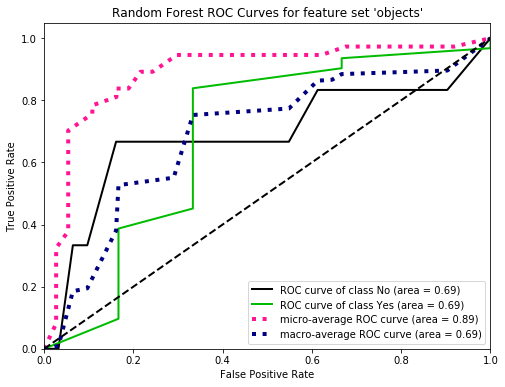

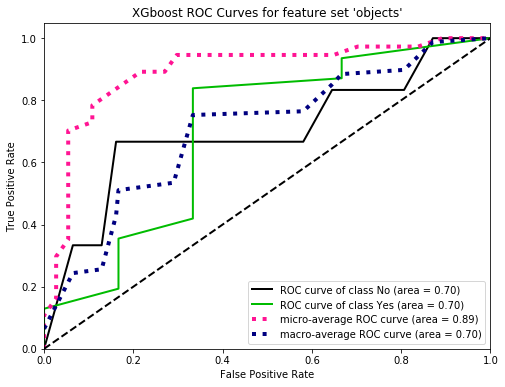

#######Running models for feature set 'objects+visual'#######
----Random Forest-----
                        predictors  Feature_importance
4                             Page            0.152480
1                             Plot            0.146387
7                            Paper            0.120283
5                             Word            0.102150
3                           Symbol            0.064053
2                           Number            0.059767
6                          Diagram            0.052353
8                       Voice only            0.048846
16            Makeup - Eyemakeup_1            0.040792
0                             Text            0.038594
10              Blur - Blurlevel_1            0.034838
9                        Glasses_1            0.032774
11      Exposure - Exposurelevel_1            0.025722
17            Makeup - Lipmakeup_1            0.024226
15            Noise - Noiselevel_1            0.020931
12  Occlusion - Foreheadoccluded_1 

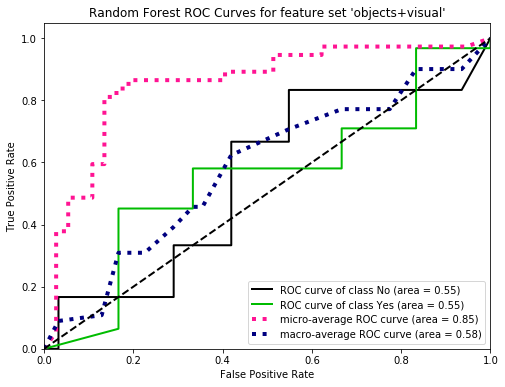

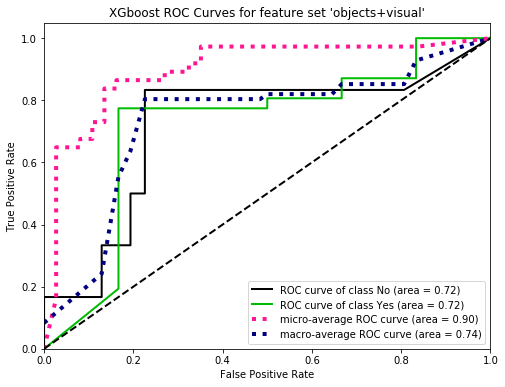

#######Running models for feature set 'objects_lt30+visual_lt30'#######
----Random Forest-----
                        predictors  Feature_importance
0                             Text            0.267056
9             Makeup - Eyemakeup_1            0.169480
3               Blur - Blurlevel_1            0.116536
1                       Voice only            0.103625
8             Noise - Noiselevel_1            0.080472
10            Makeup - Lipmakeup_1            0.075295
2                        Glasses_1            0.071998
4       Exposure - Exposurelevel_1            0.061362
7      Occlusion - Mouthoccluded_1            0.015057
5   Occlusion - Foreheadoccluded_1            0.014079
11              Hair - Invisible_1            0.013136
6        Occlusion - Eyeoccluded_1            0.011906
            Predicted No  Predicted Yes
Actual No              0              6
Actual Yes             1             30
----XGboost-----
                        predictors  Feature_importanc

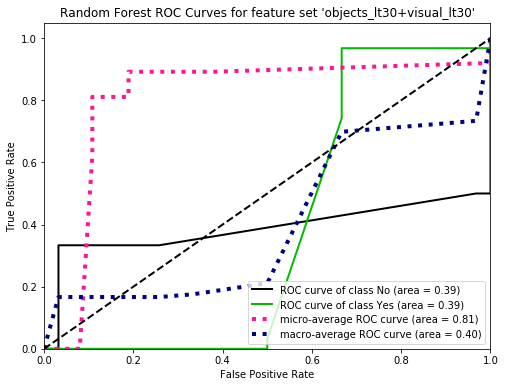

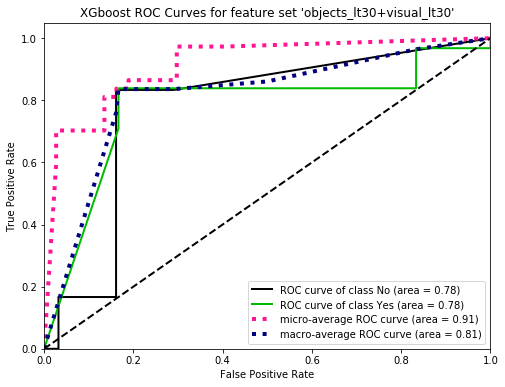

#######Running models for feature set 'objects+audio+visual'#######
----Random Forest-----
                             predictors  Feature_importance
19                                  wpm            0.141141
23  count of number of 1s/total windows            0.137820
22                      median_flatness            0.133101
24                  Pronunciation score            0.120594
20                         pitch_tuning            0.108768
1                                  Plot            0.044780
26                         audio_tone_1            0.039120
7                                 Paper            0.038558
25                       audio_gender_1            0.025827
5                                  Word            0.025796
4                                  Page            0.024086
21                   Number of speakers            0.022275
6                               Diagram            0.019684
2                                Number            0.017846
0        

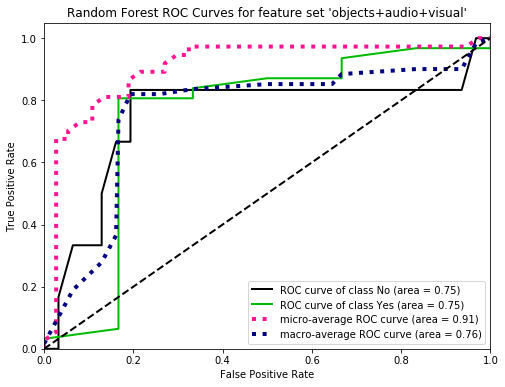

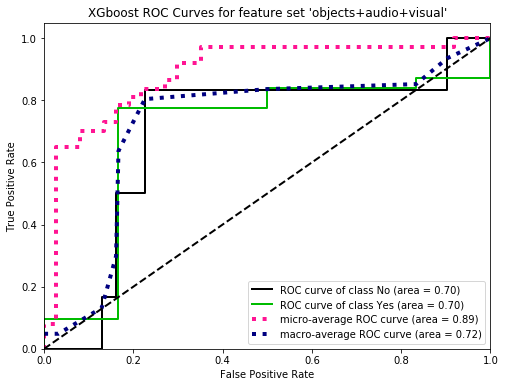

In [330]:
feat_dict={

    'objects':objects_v2,
    'objects+visual':objects_v2+visual_v2,
    'objects_lt30+visual_lt30':objects_v3+visual_v3,
    'objects+audio+visual':objects_v2+visual_v2+audio_v2,
    
    
}

for key, value in feat_dict.items():
    print(f"#######Running models for feature set '{key}'#######")

    feature_set_model_plots(df_fe,value,key)

    plt.pause(0.0001)



In [279]:
df_v1=pd.read_csv('all_features_cleaned.csv')
print(df_v1.shape)

print(df_v1.columns.values)
df_v1.select_dtypes('object_').head()

(183, 156)
['Video id' 'Number of speakers' 'cc_skill_code' 'code_desc' 'video_link'
 'published_at' 'video_title' 'video_desc' 'channel_title' 'WC' 'Analytic'
 'Clout' 'Authentic' 'Tone' 'WPS' 'Sixltr' 'Dic' 'function' 'pronoun'
 'ppron' 'i' 'we' 'you' 'shehe' 'they' 'ipron' 'article' 'prep' 'auxverb'
 'adverb' 'conj' 'negate' 'verb' 'adj' 'compare' 'interrog' 'number'
 'quant' 'affect' 'posemo' 'negemo' 'social' 'male' 'cogproc' 'insight'
 'cause' 'discrep' 'tentat' 'certain' 'differ' 'percept' 'see' 'hear'
 'feel' 'bio' 'health' 'drives' 'affiliation' 'achieve' 'power' 'reward'
 'focuspast' 'focuspresent' 'focusfuture' 'relativ' 'motion' 'space'
 'time' 'work' 'leisure' 'money' 'informal' 'netspeak' 'assent' 'nonflu'
 'AllPunc' 'Dash' 'Quote' 'Apostro' 'Parenth' 'OtherP' 'Profile faces'
 'Front faces' 'median_flatness' 'count of number of 1s/total windows'
 'pitch_tuning' 'wpm' 'blondVal' 'brownVal' 'redVal' 'blackVal' 'grayVal'
 'otherVal' 'Smile' 'Headpose - Pitch' 'Headpose - Rol

,Video id,cc_skill_code,code_desc,video_link,published_at,video_title,video_desc,channel_title,Gender,Glasses,...,Exposure - Exposurelevel,Occlusion - Foreheadoccluded,Occlusion - Eyeoccluded,Occlusion - Mouthoccluded,Noise - Noiselevel,Makeup - Eyemakeup,Makeup - Lipmakeup,Hair - Invisible,transcript,label
0,7up731HX2uA,7.RP.A.2.D,"Explain what a point (x, y) on the graph of a ...",https://www.youtube.com/watch?v=7up731HX2uA,2015-01-26T19:24:25.000Z,[7RP2c-14] Graphing Proportional Relationships...,Discover more Common Core Math at https://www....,Freckle Education,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,'Lydia is selling water bottles for two dollar...,Yes
1,7E64xzjsgpo,7.NS.A.2.C,Apply properties of operations as strategies t...,https://www.youtube.com/watch?v=7E64xzjsgpo,2015-10-12T21:06:40.000Z,Operation Properties Inverse Property 7 NS A 1...,video 5 of 5.,Math Man,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,'welcome to our flipped classroom where knowle...,Yes
2,ibZmnFcLlaA,7.SP.C.7.A,Develop a uniform probability model by assigni...,https://www.youtube.com/watch?v=ibZmnFcLlaA,2015-01-26T19:25:53.000Z,[7SP7a-15] Uniform Probability Models - Common...,Discover more Common Core Math at https://www....,Freckle Education,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,'a bag has 50 colored chips if 20 chips are re...,Yes
3,JmJAa90B_Qo,7.SP.C.7.B,Develop a probability model (which may not be ...,https://www.youtube.com/watch?v=JmJAa90B_Qo,2015-01-26T19:30:24.000Z,[7SP7b-11] Developing Probability Models - Com...,Discover more Common Core Math at https://www....,Freckle Education,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,'before the experiment Lisbeth predicted that ...,Yes
4,hlD_j3AtxGs,7.G.A.3,Describe the two-dimensional figures that resu...,https://www.youtube.com/watch?v=hlD_j3AtxGs,2014-07-10T15:45:57.000Z,Math Shorts Episode 8 - Slicing Three Dimensio...,This Math Shorts episode helps students unders...,Planet Nutshell,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,'math shirts slicing solid three-dimensional f...,Yes


In [282]:

df_v1=df_v1[~df_v1['label'].isnull()]
df_v1['label'].value_counts(dropna=False)

Yes    153
No      29
Name: label, dtype: int64

----Random Forest-----
                             predictors  Feature_importance
38                                 they            0.042092
76                                 work            0.033331
96                              percept            0.025851
94                              certain            0.025095
55                              pronoun            0.024021
68                                power            0.022461
53                                    i            0.019818
63                                  Dic            0.019467
7                                 Views            0.018454
93                               tentat            0.018342
90                              insight            0.018256
51                                quant            0.018140
91                                cause            0.017806
47                                  adj            0.017309
40                              article            0.016610
77               

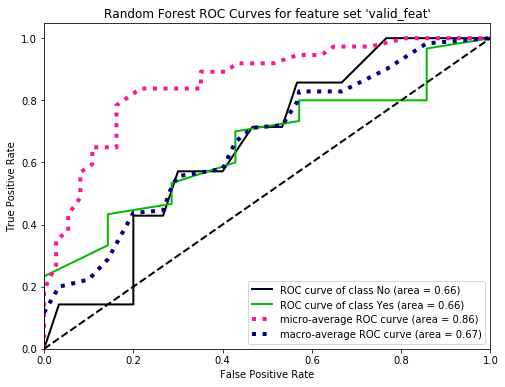

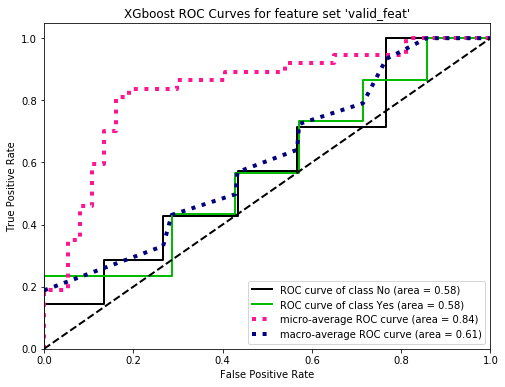

In [289]:
valid_feat=['median_flatness', 'count of number of 1s/total windows', 'Favorites', 'pitch_tuning', 'Comments', 'Dislikes', 
            'Likes', 'Views', 'Paper', 'Alphabet', 'Measurements', 'Flyer', 'Electronics', 'Driving License', 
            'Face', 'Plan', 'Handwriting', 'Diagram', 'Document', 'White Board', 'Human', 'Person', 'Word', 'Page', 'Symbol',
            'Number', 'Plot', 'Text', 'wpm', 'Profile faces', 'OtherP',   'Front faces', 'Apostro',
            'Parenth', 'Quote',  'adverb', 'you', 'shehe', 'they', 'ipron', 'article', 'prep', 'auxverb', 'conj',
            'Dash', 'negate', 'verb', 'adj', 'compare', 'interrog', 'number', 'quant', 'we', 'i', 'ppron', 'pronoun', 
             'label', 'WC', 'Analytic', 'Clout', 'Authentic', 'Tone', 'WPS', 'Sixltr', 'Dic', 'function', 'affect', 'posemo', 'negemo', 'power', 'focuspast', 
            'focuspresent', 'focusfuture', 'relativ', 'motion', 'space', 'time', 'work', 'leisure', 'money', 'informal', 
            'netspeak', 'assent', 'nonflu', 'AllPunc', 'reward', 'achieve', 'social', 'affiliation', 'male', 'cogproc', 
            'insight', 'cause', 'discrep', 'tentat', 'certain', 'differ', 'percept', 'see', 'hear', 'feel', 'bio', 
            'health', 'drives', 'Number of speakers']

valid_data=df_v1[valid_feat].fillna(0)
valid_data.to_csv('training_data_{}feat.csv'.format(len(valid_feat)),index=False)
X=valid_data.drop('label',axis=1)
Y=valid_data['label']
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.2,random_state=88)
evaluate_plot(x_train, x_test,y_train,y_test,'valid_feat')

105  valid features
72 below 100 features
----Random Forest-----
                             predictors  Feature_importance
9                                  they            0.048473
12                                 work            0.040584
3                               leisure            0.032774
30                               tentat            0.028766
19                              percept            0.028678
22                              certain            0.027246
40                             interrog            0.024390
16                               reward            0.022220
14  count of number of 1s/total windows            0.022205
39                                Views            0.021810
31                               differ            0.021474
61                             Analytic            0.020987
45                               number            0.020276
38                              compare            0.019446
11                                 

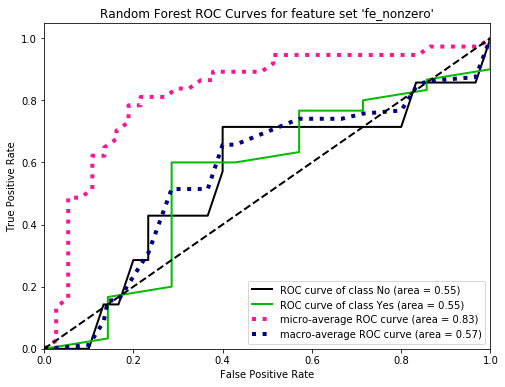

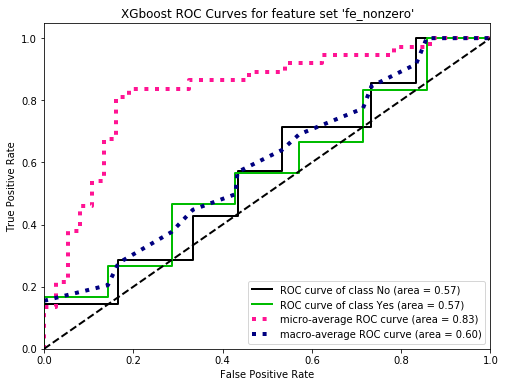

In [293]:
below_100=['Number of speakers','assent', 'bio', 'leisure', 'Word', 'negemo', 'Plot', 'hear',
       'negate', 'they', 'nonflu',  'i', 'work',
       'informal', 'count of number of 1s/total windows', 'achieve',
       'reward', 'see', 'you', 'percept', 'motion', 'focuspast',
       'certain', 'posemo', 'focusfuture', 'power', 'we', 'affect',
       'discrep', 'insight', 'tentat', 'differ', 'cause',
       'median_flatness', 'affiliation', 'pitch_tuning', 'Text', 'adj',
       'compare', 'Views', 'interrog', 'time', 'quant', 'social', 'ppron',
       'number', 'drives', 'wpm', 'Apostro', 'ipron', 'adverb', 'cogproc',
       'article', 'Authentic', 'prep', 'auxverb', 'WPS', 'Sixltr', 'Dic',
       'function', 'Clout', 'Analytic', 'WC', 'verb', 'focuspresent',
       'pronoun', 'relativ', 'space', 'Tone', 'conj', 'AllPunc', 'label']
print(f'{len(valid_feat)}  valid features\n'
     f'{len(below_100)} below 100 features')
FE_nonZero=valid_data[below_100]
X=FE_nonZero.drop('label',axis=1)
Y=FE_nonZero['label']
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.2,random_state=88)
evaluate_plot(x_train, x_test,y_train,y_test,'fe_nonzero')

----Random Forest-----
         predictors  Feature_importance
16             they            0.027175
2          Analytic            0.026953
60             work            0.024542
39           tentat            0.023615
8               Dic            0.023392
42          percept            0.023002
27         interrog            0.022262
107           Views            0.019778
43              see            0.018091
35          cogproc            0.016556
88   Headpose - Yaw            0.016278
25              adj            0.015222
7            Sixltr            0.015055
26          compare            0.015031
52           reward            0.014749
40          certain            0.014574
33           social            0.014463
41           differ            0.014222
28           number            0.014091
17            ipron            0.013953
            Predicted No  Predicted Yes
Actual No              0              7
Actual Yes             0             30
----XGboost-----


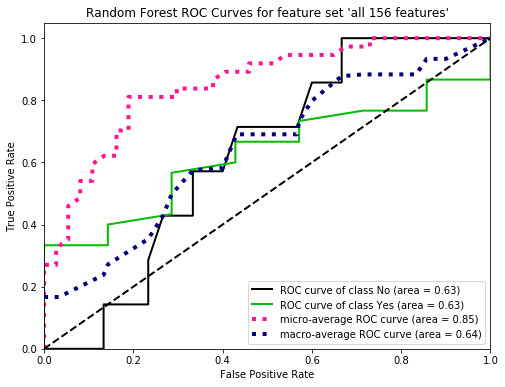

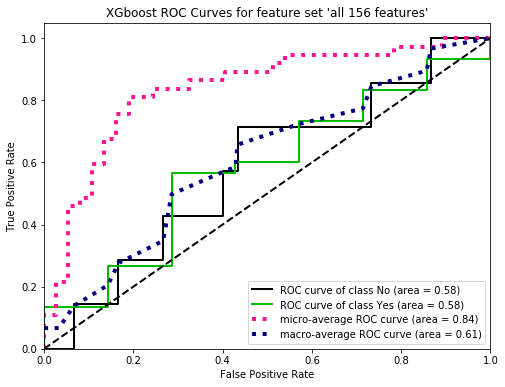

In [285]:
df_X=df_v1.select_dtypes(exclude=['object_']).fillna(0)
df_y=df_v1['label']
x_train, x_test,y_train,y_test=train_test_split(df_X,df_y,test_size=0.2,random_state=88)
evaluate_plot(x_train, x_test,y_train,y_test,'all 156 features')
# plt.pause(0.0001)